**1. Installation**

In [1]:
!pip install torch torchvision timm albumentations opencv-python scikit-learn pandas matplotlib tqdm
import os, shutil, random, gc, json, cv2
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import timm

**2. Import**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**3. Initializing the path**

In [3]:
DATA_ROOT = "/content/drive/MyDrive/Major_1/Agro_dataset/All_disease_of_Tomato_subset_10000"
OUT_DIR = "/content/drive/MyDrive/Major_1/Agro_dataset/outputttt"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

**4. Utility Function**

In [4]:
''''def is_blurry(path, thresh=100):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None: return True
    return cv2.Laplacian(img, cv2.CV_64F).var() < thresh



def build_metadata(root):
    rows = []
    root = Path(root)
    for cls in sorted(p.name for p in root.iterdir() if p.is_dir()):
        for f in (root/cls).glob('*'):
            rows.append({'path': str(f), 'label': cls})
    return pd.DataFrame(rows)

SyntaxError: incomplete input (ipython-input-458074831.py, line 1)

**5. Spliting of Data in the form of Training/Testing/Validation**

In [ ]:
'''def prepare_splits(root, out, test_size=0.15, val_size=0.15, blur_check_fraction=0.1):
    df = build_metadata(root)
    counts = df['label'].value_counts()
    valid_classes = counts[counts > 1].index
    df = df[df['label'].isin(valid_classes)]
    ok = []
    for i, row in df.iterrows():
        if not Path(row['path']).exists():
            continue
        if blur_check_fraction > 0 and random.random() < blur_check_fraction:
            if is_blurry(row['path']):
                continue
        ok.append(row)

    df_ok = pd.DataFrame(ok)


    # Remove classes with <3 samples AFTER blur check
    counts_ok = df_ok['label'].value_counts()
    valid_classes_ok = counts_ok[counts_ok > 2].index
    df_ok = df_ok[df_ok['label'].isin(valid_classes_ok)]


    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(df_ok['label'])


    # Train / Rest split
    try:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=(test_size+val_size), random_state=42)
        train_idx, rest_idx = next(sss.split(df_ok, y))
    except ValueError:
        print("Stratified split failed. Falling back to random split.")
        train_idx, rest_idx = train_test_split(range(len(df_ok)), test_size=(test_size+val_size), random_state=42)


    df_train, df_rest = df_ok.iloc[train_idx], df_ok.iloc[rest_idx]


    # Val / Test split
    val_frac = val_size / (test_size + val_size)
    y_rest = le.transform(df_rest['label'])
    try:
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=1-val_frac, random_state=42)
        val_idx, test_idx = next(sss2.split(df_rest, y_rest))
    except ValueError:
        print("Val/Test stratified split failed. Falling back to random split.")
        val_idx, test_idx = train_test_split(range(len(df_rest)), test_size=(1-val_frac), random_state=42)


    df_val, df_test = df_rest.iloc[val_idx], df_rest.iloc[test_idx]


    # Save CSVs
    Path(out).mkdir(parents=True, exist_ok=True)
    df_train.to_csv(Path(out)/"train.csv", index=False)
    df_val.to_csv(Path(out)/"val.csv", index=False)
    df_test.to_csv(Path(out)/"test.csv", index=False)


    print("Train/Val/Test splits:", len(df_train), len(df_val), len(df_test))
    print(f"Blur check applied on ~{blur_check_fraction*100}% of images")


prepare_splits(DATA_ROOT, OUT_DIR, blur_check_fraction=0.1)

**6. Dataset class**

In [4]:
class TomatoDataset(Dataset):
    def __init__(self, csv_file, img_size=224, skip_bad=True):
        self.df = pd.read_csv(csv_file)
        self.label2idx = {l: i for i, l in enumerate(sorted(self.df['label'].unique()))}
        self.idx2label = {i: l for l, i in self.label2idx.items()}
        self.skip_bad = skip_bad

        self.T = A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ColorJitter(p=0.5),
            A.Normalize(),
            ToTensorV2(),
        ])

        if self.skip_bad:
            good_rows = []
            for i, row in self.df.iterrows():
                if os.path.exists(row['path']) and cv2.imread(row['path']) is not None:
                    good_rows.append(row)
            self.df = pd.DataFrame(good_rows).reset_index(drop=True)
            print(f"✅ Dataset initialized with {len(self.df)} valid images")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        img = cv2.imread(img_path)
        if img is None:
            if self.skip_bad:
                return self.__getitem__((idx + 1) % len(self.df))
            else:
                raise FileNotFoundError(f"⚠️ Could not read image at {img_path}")
        img = img[:, :, ::-1]
        img = self.T(image=img)['image']
        label = self.label2idx[row['label']]
        return img, label

**7. Model Builder**

In [5]:
def get_model(backbone, num_classes):
    #if backbone == "efficientnet_b0":
     #   model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
      #  in_features = model.classifier[1].in_features
       # model.classifier[1] = nn.Linear(in_features, num_classes)
    if backbone == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif backbone == "mobilenetv2_100":
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
    elif backbone == "densenet121":
        model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unknown backbone: {backbone}")
    return model

**8. Training Function**

In [6]:
def train_model(backbone, train_csv, val_csv, num_classes, epochs=10, batch_size=16, lr=1e-3):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    transform = T.Compose([
        T.Resize((224,224)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(20),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        T.ToTensor(),
        T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    train_ds = TomatoDataset(train_csv)
    val_ds   = TomatoDataset(val_csv)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    model = get_model(backbone, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {"train_loss":[], "val_loss":[], "val_acc":[]}

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0
        for images, labels in tqdm(train_loader, desc=f"[{backbone}] Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, correct, total = 0,0,0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(1)
                correct += (preds==labels).sum().item()
                total += labels.size(0)
        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct/total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)

        print(f"[{backbone}] Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    return history, model


**9. Main Training loop**

In [7]:
train_csv = f"{OUT_DIR}/train.csv"
val_csv   = f"{OUT_DIR}/val.csv"
num_classes = len(pd.read_csv(train_csv)['label'].unique())

os.makedirs("models", exist_ok=True)
results = {}
for backbone in ["resnet50","mobilenetv2_100","densenet121"]:
    print("="*60)
    print(f" Training {backbone} ".center(60,"="))
    history, model = train_model(backbone, train_csv, val_csv, num_classes, epochs=10, batch_size=16)
    results[backbone] = history
    save_path = f"models/{backbone}.pt"
    torch.save(model.state_dict(), save_path)
    print(f"✅ Saved {backbone} weights to {save_path}")
    del model
    torch.cuda.empty_cache()
    gc.collect()

==================== Training resnet50 =====================
✅ Dataset initialized with 6415 valid images
✅ Dataset initialized with 1375 valid images
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]
[resnet50] Epoch 1/10: 100%|██████████| 401/401 [01:11<00:00,  5.62it/s]


[resnet50] Epoch 1/10 | Train Loss: 1.1707 | Val Loss: 0.9413 | Val Acc: 0.6975


[resnet50] Epoch 2/10: 100%|██████████| 401/401 [01:11<00:00,  5.59it/s]


[resnet50] Epoch 2/10 | Train Loss: 0.7305 | Val Loss: 0.5867 | Val Acc: 0.7898


[resnet50] Epoch 3/10: 100%|██████████| 401/401 [01:13<00:00,  5.48it/s]


[resnet50] Epoch 3/10 | Train Loss: 0.5687 | Val Loss: 0.6285 | Val Acc: 0.7978


[resnet50] Epoch 4/10: 100%|██████████| 401/401 [01:12<00:00,  5.53it/s]


[resnet50] Epoch 4/10 | Train Loss: 0.4945 | Val Loss: 0.7367 | Val Acc: 0.7542


[resnet50] Epoch 5/10: 100%|██████████| 401/401 [01:12<00:00,  5.50it/s]


[resnet50] Epoch 5/10 | Train Loss: 0.4441 | Val Loss: 0.4573 | Val Acc: 0.8509


[resnet50] Epoch 6/10: 100%|██████████| 401/401 [01:14<00:00,  5.41it/s]


[resnet50] Epoch 6/10 | Train Loss: 0.3811 | Val Loss: 0.3708 | Val Acc: 0.8720


[resnet50] Epoch 7/10: 100%|██████████| 401/401 [01:14<00:00,  5.39it/s]


[resnet50] Epoch 7/10 | Train Loss: 0.3478 | Val Loss: 0.4664 | Val Acc: 0.8429


[resnet50] Epoch 8/10: 100%|██████████| 401/401 [01:12<00:00,  5.55it/s]


[resnet50] Epoch 8/10 | Train Loss: 0.3184 | Val Loss: 0.3896 | Val Acc: 0.8640


[resnet50] Epoch 9/10: 100%|██████████| 401/401 [01:13<00:00,  5.48it/s]


[resnet50] Epoch 9/10 | Train Loss: 0.3020 | Val Loss: 0.3676 | Val Acc: 0.8691


[resnet50] Epoch 10/10: 100%|██████████| 401/401 [01:12<00:00,  5.55it/s]


[resnet50] Epoch 10/10 | Train Loss: 0.2720 | Val Loss: 0.3267 | Val Acc: 0.8836
✅ Saved resnet50 weights to models/resnet50.pt
================= Training mobilenetv2_100 =================
✅ Dataset initialized with 6415 valid images
✅ Dataset initialized with 1375 valid images
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 124MB/s]
[mobilenetv2_100] Epoch 1/10: 100%|██████████| 401/401 [00:58<00:00,  6.89it/s]


[mobilenetv2_100] Epoch 1/10 | Train Loss: 1.0044 | Val Loss: 0.5309 | Val Acc: 0.8182


[mobilenetv2_100] Epoch 2/10: 100%|██████████| 401/401 [00:59<00:00,  6.71it/s]


[mobilenetv2_100] Epoch 2/10 | Train Loss: 0.6513 | Val Loss: 0.5231 | Val Acc: 0.8313


[mobilenetv2_100] Epoch 3/10: 100%|██████████| 401/401 [00:57<00:00,  6.94it/s]


[mobilenetv2_100] Epoch 3/10 | Train Loss: 0.5381 | Val Loss: 0.4721 | Val Acc: 0.8364


[mobilenetv2_100] Epoch 4/10: 100%|██████████| 401/401 [00:57<00:00,  6.95it/s]


[mobilenetv2_100] Epoch 4/10 | Train Loss: 0.5044 | Val Loss: 0.4287 | Val Acc: 0.8662


[mobilenetv2_100] Epoch 5/10: 100%|██████████| 401/401 [38:35<00:00,  5.77s/it]


[mobilenetv2_100] Epoch 5/10 | Train Loss: 0.4386 | Val Loss: 0.3991 | Val Acc: 0.8582


[mobilenetv2_100] Epoch 6/10: 100%|██████████| 401/401 [00:57<00:00,  7.01it/s]


[mobilenetv2_100] Epoch 6/10 | Train Loss: 0.4255 | Val Loss: 0.4084 | Val Acc: 0.8727


[mobilenetv2_100] Epoch 7/10: 100%|██████████| 401/401 [00:58<00:00,  6.88it/s]


[mobilenetv2_100] Epoch 7/10 | Train Loss: 0.3587 | Val Loss: 0.3755 | Val Acc: 0.8793


[mobilenetv2_100] Epoch 8/10: 100%|██████████| 401/401 [00:57<00:00,  6.97it/s]


[mobilenetv2_100] Epoch 8/10 | Train Loss: 0.3457 | Val Loss: 0.3140 | Val Acc: 0.8960


[mobilenetv2_100] Epoch 9/10: 100%|██████████| 401/401 [00:57<00:00,  6.96it/s]


[mobilenetv2_100] Epoch 9/10 | Train Loss: 0.3229 | Val Loss: 0.3005 | Val Acc: 0.8982


[mobilenetv2_100] Epoch 10/10: 100%|██████████| 401/401 [00:58<00:00,  6.82it/s]


[mobilenetv2_100] Epoch 10/10 | Train Loss: 0.3072 | Val Loss: 0.3983 | Val Acc: 0.8764
✅ Saved mobilenetv2_100 weights to models/mobilenetv2_100.pt
=================== Training densenet121 ===================
✅ Dataset initialized with 6415 valid images
✅ Dataset initialized with 1375 valid images
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 212MB/s]
[densenet121] Epoch 1/10: 100%|██████████| 401/401 [01:18<00:00,  5.12it/s]


[densenet121] Epoch 1/10 | Train Loss: 1.2627 | Val Loss: 0.9472 | Val Acc: 0.6589


[densenet121] Epoch 2/10: 100%|██████████| 401/401 [01:19<00:00,  5.06it/s]


[densenet121] Epoch 2/10 | Train Loss: 0.8822 | Val Loss: 0.7321 | Val Acc: 0.7593


[densenet121] Epoch 3/10: 100%|██████████| 401/401 [01:17<00:00,  5.15it/s]


[densenet121] Epoch 3/10 | Train Loss: 0.7010 | Val Loss: 0.6640 | Val Acc: 0.7775


[densenet121] Epoch 4/10: 100%|██████████| 401/401 [01:19<00:00,  5.03it/s]


[densenet121] Epoch 4/10 | Train Loss: 0.5972 | Val Loss: 0.5021 | Val Acc: 0.8269


[densenet121] Epoch 5/10: 100%|██████████| 401/401 [01:19<00:00,  5.04it/s]


[densenet121] Epoch 5/10 | Train Loss: 0.5670 | Val Loss: 0.4396 | Val Acc: 0.8400


[densenet121] Epoch 6/10: 100%|██████████| 401/401 [01:17<00:00,  5.16it/s]


[densenet121] Epoch 6/10 | Train Loss: 0.4973 | Val Loss: 0.4992 | Val Acc: 0.8233


[densenet121] Epoch 7/10: 100%|██████████| 401/401 [01:17<00:00,  5.17it/s]


[densenet121] Epoch 7/10 | Train Loss: 0.4710 | Val Loss: 0.3548 | Val Acc: 0.8756


[densenet121] Epoch 8/10: 100%|██████████| 401/401 [01:20<00:00,  4.96it/s]


[densenet121] Epoch 8/10 | Train Loss: 0.4470 | Val Loss: 0.4095 | Val Acc: 0.8647


[densenet121] Epoch 9/10: 100%|██████████| 401/401 [01:19<00:00,  5.06it/s]


[densenet121] Epoch 9/10 | Train Loss: 0.3774 | Val Loss: 0.5104 | Val Acc: 0.8327


[densenet121] Epoch 10/10: 100%|██████████| 401/401 [01:18<00:00,  5.13it/s]


[densenet121] Epoch 10/10 | Train Loss: 0.3814 | Val Loss: 0.3743 | Val Acc: 0.8662
✅ Saved densenet121 weights to models/densenet121.pt


**Train by EfficientNet-B0**

In [18]:
# Train EfficientNet-B0
os.makedirs("models", exist_ok=True)
print("="*60)
print(" Training EfficientNet-B0 ".center(60,"="))
history, model = train_model("efficientnet_b0", train_csv, val_csv, num_classes, epochs=10, batch_size=16)

save_path = "models/efficientnet_b0.pt"
torch.save(model.state_dict(), save_path)
print(f"✅ Saved EfficientNet-B0 weights to {save_path}")

del model
torch.cuda.empty_cache()
gc.collect()


================= Training EfficientNet-B0 =================
✅ Dataset initialized with 6415 valid images
✅ Dataset initialized with 1375 valid images
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 188MB/s]
[efficientnet_b0] Epoch 1/10: 100%|██████████| 401/401 [01:01<00:00,  6.56it/s]


[efficientnet_b0] Epoch 1/10 | Train Loss: 0.9778 | Val Loss: 0.5634 | Val Acc: 0.8145


[efficientnet_b0] Epoch 2/10: 100%|██████████| 401/401 [01:00<00:00,  6.58it/s]


[efficientnet_b0] Epoch 2/10 | Train Loss: 0.5891 | Val Loss: 0.4782 | Val Acc: 0.8407


[efficientnet_b0] Epoch 3/10: 100%|██████████| 401/401 [01:02<00:00,  6.45it/s]


[efficientnet_b0] Epoch 3/10 | Train Loss: 0.4543 | Val Loss: 0.4178 | Val Acc: 0.8633


[efficientnet_b0] Epoch 4/10: 100%|██████████| 401/401 [01:02<00:00,  6.38it/s]


[efficientnet_b0] Epoch 4/10 | Train Loss: 0.4202 | Val Loss: 0.3797 | Val Acc: 0.8727


[efficientnet_b0] Epoch 5/10: 100%|██████████| 401/401 [01:02<00:00,  6.41it/s]


[efficientnet_b0] Epoch 5/10 | Train Loss: 0.3846 | Val Loss: 0.4093 | Val Acc: 0.8647


[efficientnet_b0] Epoch 6/10: 100%|██████████| 401/401 [01:00<00:00,  6.68it/s]


[efficientnet_b0] Epoch 6/10 | Train Loss: 0.3242 | Val Loss: 0.2324 | Val Acc: 0.9236


[efficientnet_b0] Epoch 7/10: 100%|██████████| 401/401 [01:02<00:00,  6.45it/s]


[efficientnet_b0] Epoch 7/10 | Train Loss: 0.3041 | Val Loss: 0.2367 | Val Acc: 0.9178


[efficientnet_b0] Epoch 8/10: 100%|██████████| 401/401 [01:05<00:00,  6.11it/s]


[efficientnet_b0] Epoch 8/10 | Train Loss: 0.2789 | Val Loss: 0.2719 | Val Acc: 0.9127


[efficientnet_b0] Epoch 9/10: 100%|██████████| 401/401 [01:00<00:00,  6.59it/s]


[efficientnet_b0] Epoch 9/10 | Train Loss: 0.2670 | Val Loss: 0.2988 | Val Acc: 0.9033


[efficientnet_b0] Epoch 10/10: 100%|██████████| 401/401 [01:00<00:00,  6.60it/s]


[efficientnet_b0] Epoch 10/10 | Train Loss: 0.2425 | Val Loss: 0.3072 | Val Acc: 0.8967
✅ Saved EfficientNet-B0 weights to models/efficientnet_b0.pt


569

In [54]:
with open(f"{OUT_DIR}/label2idx.json", "w") as f:
    json.dump(label2idx, f, indent=4)

with open(f"{OUT_DIR}/idx2label.json", "w") as f:
    json.dump(idx2label, f, indent=4)

print(f"✅ Saved label mappings to {OUT_DIR}/label2idx.json and idx2label.json")

✅ Saved label mappings to /content/drive/MyDrive/Major_1/Agro_dataset/outputttt/label2idx.json and idx2label.json


In [55]:
# Extract final validation accuracy
final_val_acc = history['val_acc'][-1]
print(f"✅ Final Validation Accuracy of EfficientNet-B0: {final_val_acc:.4f}")


✅ Final Validation Accuracy of EfficientNet-B0: 0.8967


**10. Save training Loop**

In [56]:
results_df = pd.DataFrame({b: pd.Series(h['val_acc']) for b,h in results.items()})
results_df.to_csv(f"{OUT_DIR}/training_results.csv", index=False)
print(f"📊 Training results saved to {OUT_DIR}/training_results.csv")

df = pd.read_csv(f"{OUT_DIR}/train.csv")
label2idx = {l: i for i, l in enumerate(sorted(df['label'].unique()))}
idx2label = {i: l for l, i in label2idx.items()}
num_classes = len(label2idx)

📊 Training results saved to /content/drive/MyDrive/Major_1/Agro_dataset/outputttt/training_results.csv


**11. Comparision Between Model**

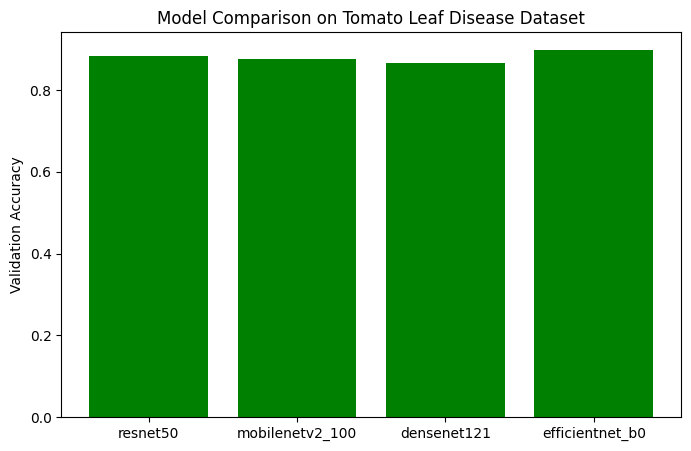

Final Validation Accuracies: {'resnet50': 0.8836363636363637, 'mobilenetv2_100': 0.8763636363636363, 'densenet121': 0.8661818181818182, 'efficientnet_b0': 0.8967272727272727}


In [57]:
results["efficientnet_b0"] = history
names = list(results.keys())
val_acc_scores = [h['val_acc'][-1] for h in results.values()]
plt.figure(figsize=(8,5))
plt.bar(names, val_acc_scores, color="green")
plt.ylabel("Validation Accuracy")
plt.title("Model Comparison on Tomato Leaf Disease Dataset")
plt.show()
print("Final Validation Accuracies:", dict(zip(names,val_acc_scores)))

**12. Remedies Knowledge Base**

In [58]:
remedies = {
    "Bacterial spot": {"description": "Caused by Xanthomonas spp. Small, water-soaked spots that turn dark and necrotic.",
                       "actions": ["Apply copper-based bactericides.","Avoid overhead irrigation and overcrowding.","Rotate crops and use certified disease-free seeds."]},
    "Early blight": {"description": "Caused by Alternaria solani. Brown concentric rings on older leaves.",
                     "actions": ["Remove and destroy infected leaves.","Spray fungicides containing chlorothalonil or mancozeb.","Rotate crops with non-solanaceous plants."]},
    "Healthy": {"description": "No visible disease symptoms detected.",
                "actions": ["Maintain good irrigation and fertilization.","Regularly monitor for early disease symptoms.","Practice crop rotation for long-term health."]},
    "Late blight": {"description": "Caused by Phytophthora infestans. Water-soaked, greasy lesions spreading rapidly.",
                    "actions": ["Immediately remove and destroy infected plants.","Apply fungicides like metalaxyl or mancozeb.","Avoid overhead watering, improve air circulation."]},
    "Leaf Mold": {"description": "Caused by Passalora fulva. Yellow spots on upper surface, olive-green mold beneath.",
                   "actions": ["Improve ventilation, reduce humidity in greenhouses.","Apply sulfur or copper-based fungicides.","Remove plant debris after harvest."]},
    "Powdery Mildew": {"description": "White powdery fungal growth on leaf surfaces.",
                       "actions": ["Spray sulfur-based fungicides or potassium bicarbonate.","Ensure proper spacing and ventilation.","Use resistant varieties when available."]},
    "Septoria leaf spot": {"description": "Caused by Septoria lycopersici. Small circular spots with dark borders.",
                           "actions": ["Prune lower leaves to improve airflow.","Apply fungicides containing chlorothalonil.","Disinfect tools and remove infected debris."]},
    "Spider mites Two spotted spider mite": {"description": "Tiny spider-like pests causing stippling, yellowing, and fine webbing.",
                                             "actions": ["Spray neem oil or insecticidal soap.","Introduce predatory mites (biological control).","Keep plants well-watered; mites thrive in dry conditions."]},
    "Target spot": {"description": "Caused by Corynespora cassiicola. Brown lesions with concentric rings.",
                    "actions": ["Use fungicides (chlorothalonil, copper oxychloride).","Remove infected leaves promptly.","Avoid excessive nitrogen fertilization."]},
    "Tomato mosaic virus": {"description": "Virus causing mottled light/dark green areas, distorted leaves.",
                            "actions": ["Remove and destroy infected plants immediately.","Avoid tobacco handling near plants.","Disinfect tools and hands with 10% bleach."]},
    "Tomato yellow leaf curl virus": {"description": "Transmitted by whiteflies. Causes yellowing, curling, and stunted growth.",
                                      "actions": ["Use insect-proof netting to reduce whitefly exposure.","Apply neem oil or insecticides against whiteflies.","Grow resistant tomato varieties."]}
}
with open(f"{OUT_DIR}/remedies.json","w") as f:
    json.dump(remedies,f,indent=4)
print("✅ Remedies knowledge base saved")

✅ Remedies knowledge base saved


**13. Prediction & Remedies**

In [59]:
def predict_image_with_gradcam(image_path, model_path, backbone, num_classes, label_map, remedy_path=f"{OUT_DIR}/remedies.json"):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load remedies
    with open(remedy_path) as f:
        remedy_db = json.load(f)

    # Load model using torchvision for consistency with training
    if backbone == "efficientnet_b0":
        model = models.efficientnet_b0(weights=None, num_classes=num_classes)
    elif backbone == "resnet50":
        model = models.resnet50(weights=None, num_classes=num_classes)
    elif backbone == "mobilenetv2_100":
        model = models.mobilenet_v2(weights=None, num_classes=num_classes)
    elif backbone == "densenet121":
        model = models.densenet121(weights=None, num_classes=num_classes)
    else:
        raise ValueError(f"Unknown backbone: {backbone}")


    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device).eval()

    # Preprocess image
    T = A.Compose([A.Resize(224,224), A.Normalize(), ToTensorV2()])
    img_bgr = cv2.imread(image_path)
    img_rgb = img_bgr[:,:,::-1]
    # Resize the original image to match the heatmap size
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    x = T(image=img_rgb)['image'].unsqueeze(0).to(device)


    # Grad-CAM Hook
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hook on last conv layer - need to adapt for different backbones
    last_conv = None
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d)):
            last_conv = m
    if last_conv is None: raise ValueError("No Conv2d layer found for Grad-CAM")

    last_conv.register_forward_hook(forward_hook)
    last_conv.register_backward_hook(backward_hook)

    # Forward pass
    logits = model(x)
    probs = torch.nn.functional.softmax(logits, dim=1)[0]
    pred_idx = probs.argmax().item()
    label = label_map[pred_idx]
    confidence = float(probs[pred_idx])
    remedy = remedy_db.get(label, {"description":"N/A","actions":[]})

    # Backward pass
    model.zero_grad()
    logits[0,pred_idx].backward()
    grad = gradients[0].cpu().data.numpy()[0]
    act  = activations[0].cpu().data.numpy()[0]

    weights = grad.mean(axis=(1,2))
    cam = np.zeros(act.shape[1:], dtype=np.float32)
    for i,w in enumerate(weights):
        cam += w * act[i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224,224))
    cam = cam - cam.min()
    cam = cam / cam.max()
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    # Use the resized original image for overlay
    overlay = cv2.addWeighted(img_rgb_resized, 0.6, heatmap[:,:,::-1], 0.4, 0)

    # Display
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM: {label} ({confidence:.2f})")
    plt.axis("off")
    plt.show()

    return label, confidence, remedy

**14. Example test**

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


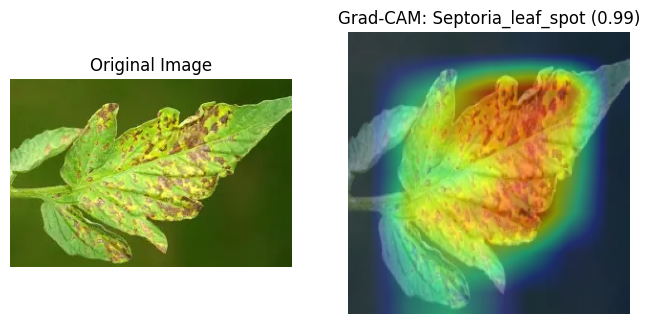

Prediction: Septoria_leaf_spot
Confidence: 0.987

Description: Caused by Septoria lycopersici. Small circular spots with dark borders.
Suggested Actions:
- Prune lower leaves to improve airflow.
- Apply fungicides containing chlorothalonil.
- Disinfect tools and remove infected debris.


In [60]:
import json
import pandas as pd

# Load remedies
with open(f"{OUT_DIR}/remedies.json") as f:
    remedy_db = json.load(f)

# Define test_image and best_model
test_image = "/content/drive/MyDrive/Major_1/Agro_dataset/Test/download.webp"  # Put your test image path
best_model = f"models/efficientnet_b0.pt"

# Define idx2label
train_csv = f"{OUT_DIR}/train.csv"
df = pd.read_csv(train_csv)
label2idx = {l: i for i, l in enumerate(sorted(df['label'].unique()))}
idx2label = {i: l for l, i in label2idx.items()}


# Prediction (example)
label, conf, remedy = predict_image_with_gradcam(test_image, best_model, "efficientnet_b0", len(idx2label), idx2label, remedy_path=f"{OUT_DIR}/remedies.json")

# Normalize remedies dict
remedy_db_norm = {k.strip().lower(): v for k,v in remedy_db.items()}

# Normalize prediction label
label_key = label.replace("_"," ").strip().lower()

# Fetch remedy
remedy = remedy_db_norm.get(label_key, {"description":"❌ Remedy not found","actions":[]})

print("Prediction:", label)
print("Confidence:", round(conf, 3))
print("\nDescription:", remedy["description"])
print("Suggested Actions:")
for act in remedy["actions"]:
    print("-", act)

**PHASE+TAKE 2**